# TP1 - Parte B: Classificação de Atividades Humanas 
### Tópicos de Ciência dos Dados - MECD (2022/2023)

### Autores

- Duarte Meneses - 2019216949
- Patricia Costa - 2019213995


In [1]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd

## 4.5 e 4.6 da Parte A

In [2]:
activities = np.array(['Stand', 'Sit', 'Sit and Talk', 'Walk', 'Walk and Talk', 'Climb Stair (up/down)',
    'Climb Stair (up/down) and talk', 'Stand -> Sit', 'Sit -> Stand', 'Stand -> Sit and talk', 'Sit -> Stand and talk',
    'Stand -> walk', 'Walk -> stand', 'Stand -> climb stairs (up/down)(and talk)', 'Climb stairs (up/down) -> walk',
    'Climb stairs (up/down) and talk -> walk and talk'])
    
Acc_features = pd.read_csv("dataset/Acc_features.csv").drop(columns='Unnamed: 0')
Gyr_features = pd.read_csv("dataset/Gyr_features.csv").drop(columns=['Unnamed: 0','Label'])
Mag_features = pd.read_csv("dataset/Mag_features.csv").drop(columns=['Unnamed: 0', 'Label'])

new_data = pd.concat([Acc_features, Gyr_features, Mag_features], axis=1)
new_data.to_csv('features.csv', encoding='utf-8')
display(new_data) 

new_target = np.array(new_data["Label"])
feature_data = np.array(new_data.drop(columns = ["Label"]))

,Label,Acc X Mean,Acc X Median,Acc X Std,Acc X Variance,Acc X RMS,Acc X AD,Acc X Skew,Acc X Kurtosis,Acc X IQR,...,Mag Z acc Z Corr,Mag X gyr X Corr,Mag X gyr Y Corr,Mag X gyr Z Corr,Mag Y gyr X Corr,Mag Y gyr Y Corr,Mag Y gyr Z Corr,Mag Z gyr X Corr,Mag Z gyr Y Corr,Mag Z gyr Z Corr
0,Stand,2.816928,2.81290,0.081657,0.006668,2.818100,-0.000820,0.104070,0.486731,0.084675,...,0.538935,0.288415,-0.039466,-0.261845,0.319700,-0.137996,-0.320163,-0.608719,0.247963,0.599854
1,Stand,2.864813,2.86200,0.088376,0.007810,2.866162,0.001941,-0.237104,-0.098164,0.135050,...,0.844737,-0.477185,-0.213984,0.385307,-0.190807,-0.281080,0.065046,0.434173,0.272281,-0.243218
2,Stand,2.646591,2.80950,0.347139,0.120506,2.669039,-0.011722,-0.984057,-0.323593,0.464225,...,-0.773026,-0.399344,-0.234917,0.380753,0.428215,0.272995,-0.462982,0.414267,0.233638,-0.398286
3,Stand,2.212950,2.09150,0.285796,0.081679,2.231149,-0.008253,0.830326,-0.620484,0.455650,...,-0.662408,0.547276,0.405573,-0.486648,-0.267835,-0.202777,0.193784,-0.513572,-0.399738,0.459841
4,Stand,2.058188,2.05515,0.102485,0.010503,2.060713,0.001548,0.153356,0.366587,0.133325,...,0.120578,-0.024781,-0.101842,-0.099390,-0.099077,-0.049309,-0.077035,0.184977,0.288267,0.136665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14483,Climb stairs (up/down) and talk -> walk and talk,-2.100210,-2.19370,0.641578,0.411623,2.195101,-0.003014,0.470363,-0.706343,0.992650,...,-0.018973,0.118220,0.258170,-0.052384,0.068988,0.407538,0.036470,0.223724,-0.114251,0.030868
14484,Climb stairs (up/down) and talk -> walk and talk,3.425963,4.08130,1.693263,2.867140,3.817886,-0.035674,-1.723238,2.626517,1.417625,...,-0.726469,-0.551289,0.193614,0.176818,-0.063941,-0.482605,-0.523068,0.652333,-0.212316,-0.115947
14485,Climb stairs (up/down) and talk -> walk and talk,2.307871,2.18690,1.030087,1.061080,2.525261,0.024127,0.010703,0.621858,0.955350,...,0.189340,-0.394748,-0.056330,0.030090,0.067419,0.096801,0.058462,0.371020,0.462721,0.366293
14486,Climb stairs (up/down) and talk -> walk and talk,1.404052,1.36710,0.719179,0.517218,1.575915,0.010513,-0.280569,0.222744,0.997815,...,0.072190,0.190854,0.447516,0.256721,0.279052,0.443746,0.507358,-0.002371,-0.630569,-0.392307


### 4.5. ReliefF

In [3]:
from ReliefF import ReliefF

def reliefF(x, y):
    fs = ReliefF(n_features_to_keep=10)
    fs.fit_transform(x, y)

    return fs.top_features[:10]

### 4.6. Fisher Score

In [4]:
from skfeature.function.similarity_based import fisher_score

def fisherScore(x, y):
    return fisher_score.fisher_score(x, y)

### 4.6.1. 10 melhores features: ReliefF vs Fisher Score

In [5]:
tenBest_r = reliefF(feature_data,new_target)
tenBest_f = fisherScore(feature_data, new_target)
tenBest_f = tenBest_f[:10]

features = pd.DataFrame(columns=["Fisher Score", "ReliefF"])

column_names = new_data.columns.values.tolist()

names_r = []
for n in tenBest_r:
    names_r.append(column_names[n])

names_f = []
for n in tenBest_f:
    names_f.append(column_names[n])

features["Fisher Score"] = names_f
features["ReliefF"] = names_r

display(features)

,Fisher Score,ReliefF
0,Mag X Z Corr,Mag X Kurtosis
1,Acc Y IQR,Mag Z Kurtosis
2,Acc AVH,Mag Z Mean
3,Mag Z Median,Mag Y Kurtosis
4,Mag Z AD,Mag X Mean
5,Gyr Z ZCR,Mag Y Mean
6,Mag Z RMS,Mag Z RMS
7,Acc Z IQR,Mag X RMS
8,Gyr Z Kurtosis,Mag Y RMS
9,Acc X Z Corr,Gyr Y Mean


### 4.6.2. Vantagens e Desvantagens
- **Vantagens:**
    - Redução do número de features, ou seja, redução da memória necessária (compressão)
    - Diminuição do tempo necessário de execução do código
    - Mais facilidade na visualização e interpretação dos dados visto que a dimensionalidade é reduzida
    - Eliminação de features que não iriam interessar muito para os algoritmos utilizados nos próximos pontos
    - Basicamente, todas as vantagens do PCA sem que se perca a interpretabilidade como nesse algoritmo<br><br>
- **Desvantagens:**
    - Possível perda de informação (não se sabe o número ideal de features sem experimentar)

## Parte B


### 1.1. Data Splitting

### 1.1.1. Train-Test (TT) e Train-Validation-Test data split

In [6]:
from sklearn.model_selection import train_test_split
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

def train_test(data, target, train_size):

    x_train, x_test, y_train, y_test = train_test_split(data, target, train_size=train_size)

    trainTest = {"TRAIN": [x_train, y_train], "TEST": [x_test, y_test]}

    return trainTest

def train_validation_test(data, target, train_size, test_size):

    x_train, x_rem, y_train, y_rem = train_test_split(data, target, train_size=train_size)

    # 1 - train_size -> correponde agora ao nosso 100%(1)
    # test_size -> test_size / (1-train_size)

    test = test_size / (1-train_size)

    x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, test_size = test)

    trainValidation = {"TRAIN": [x_train, y_train], "TEST": [x_test, y_test], "VALIDATION": [x_valid, y_valid]}
    
    return trainValidation



### 1.1.2. K-fold data split

In [7]:
from sklearn.model_selection import KFold
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

def k_fold(x, y, n_splits):
    kf = KFold(n_splits=n_splits, shuffle = True)
    kfold = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        kfold.append({"TRAIN": [x_train, y_train], "TEST": [x_test, y_test]})
    
    return kfold

In [8]:
#Testes
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])

print("--Train Test--\n")
trainTest = train_test(X, y, 0.7)
display(trainTest)

print("\n--Train Validation Test--\n")
trainValidation = train_validation_test(X, y, 0.4, 0.3)
display(trainValidation)

print("\n--K Fold--\n")
kFold = k_fold(X, y, 4)
display(kFold)

--Train Test--



{'TRAIN': [array([[1, 2],
         [1, 2]]),
  array([1, 3])],
 'TEST': [array([[3, 4],
         [3, 4]]),
  array([2, 4])]}


--Train Validation Test--



{'TRAIN': [array([[3, 4]]), array([4])],
 'TEST': [array([[1, 2],
         [3, 4]]), array([1, 2])],
 'VALIDATION': [array([[1, 2]]), array([3])]}


--K Fold--



[{'TRAIN': [array([[1, 2],
          [3, 4],
          [3, 4]]),
   array([1, 2, 4])],
  'TEST': [array([[1, 2]]), array([3])]},
 {'TRAIN': [array([[1, 2],
          [3, 4],
          [1, 2]]),
   array([1, 2, 3])],
  'TEST': [array([[3, 4]]), array([4])]},
 {'TRAIN': [array([[3, 4],
          [1, 2],
          [3, 4]]),
   array([2, 3, 4])],
  'TEST': [array([[1, 2]]), array([1])]},
 {'TRAIN': [array([[1, 2],
          [1, 2],
          [3, 4]]),
   array([1, 3, 4])],
  'TEST': [array([[3, 4]]), array([2])]}]

### 1.2. Métricas de exactidação

In [9]:
#Teste
true = [2, 0, 2, 2, 0, 1]
pred = [0, 0, 2, 2, 0, 2]

-> Explicação do parâmetro average

**'binary'**:
Only report results for the class specified by pos_label. This is applicable only if targets (y_{true,pred}) are binary.

**'micro'**:
Calculate metrics globally by counting the total true positives, false negatives and false positives.

**'macro'**:
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

**'weighted'**:
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

**'samples'**:
Calculate metrics for each instance, and find their average (only meaningful for multilabel classification where this differs from accuracy_score).

,Metrics
Recall,0.666667
Precision,0.555556
F1-score,0.600000


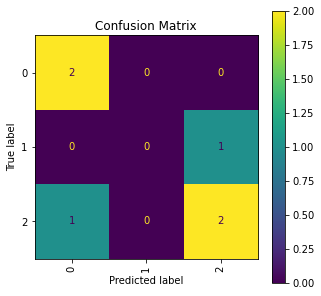

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
from sklearn.metrics import recall_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
from sklearn.metrics import precision_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score
from sklearn.metrics import f1_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

def metrics(true, pred, printar = False):

    cm = confusion_matrix(true, pred)
    rs = recall_score(true, pred, average='weighted', zero_division=0)
    ps = precision_score(true, pred, average='weighted', zero_division=0)
    f1 = f1_score(true, pred, average='weighted', zero_division=0)

    if(printar):
        print('Confusion Matrix:\n', cm)
        print('\nRecall: ', rs)
        print('\nPrecision: ', ps)
        print('\nF1-score: ', f1)
        print('-'*50)

    return [cm, rs, ps, f1]

def mais_bonito(cm, rs, ps, f1, labels):

    metricsFrame = pd.DataFrame([rs, ps, f1], columns=['Metrics']).rename(index={0: 'Recall', 1: 'Precision', 2: 'F1-score'})
    display(metricsFrame)

    try:
        cmFrame = pd.DataFrame(cm, columns=labels, index=labels).style.set_caption("Confusion Matrix")
        #display(cmFrame)

        cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
        _, ax = plt.subplots(figsize=(5,5))
        cmp.plot(ax=ax)
        ax.set_title("Confusion Matrix")
        ax.xaxis.set_ticklabels(labels, rotation=90)
        ax.yaxis.set_ticklabels(labels)
        plt.show()

    except:
        cmFrame = pd.DataFrame(cm).style.set_caption("Confusion Matrix")
        display(cmFrame)

cm, rs, ps, f1 = metrics(true, pred)
mais_bonito(cm, rs, ps, f1, [0,1,2])



### 2.1. Dataset

In [11]:
iris = datasets.load_iris()

data = iris.data
target = iris.target

display(iris)

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

### 2.1. k-Nearest Neighbours

In [12]:
from sklearn.neighbors import KNeighborsClassifier

def K_neighbors_classifier(x, y, k):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(x, y)

    return neigh


### 2.1.1. Train-only

,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


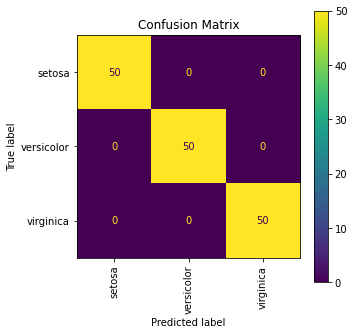

In [13]:
def TO_211(x, y, labels, k):
    neigh = K_neighbors_classifier(x, y, k)
    pred = neigh.predict(x)
    true = y
    cm, rs, ps, f1 = metrics(true, pred)
    
    mais_bonito(cm, rs, ps, f1, labels)

TO_211(data, target, iris["target_names"], 1)


### 2.1.1. TT 70-30

,Metrics
Recall,0.955556
Precision,0.955556
F1-score,0.955556


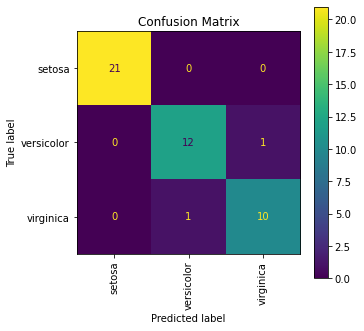

In [14]:
def TT_211(x, y, labels, k):
    trainTest = train_test(x, y, 0.7)
    neigh = K_neighbors_classifier(trainTest['TRAIN'][0], trainTest['TRAIN'][1], k)
    pred = neigh.predict(trainTest['TEST'][0])
    true = trainTest['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)
    
    mais_bonito(cm, rs, ps, f1, labels)

TT_211(data, target, iris["target_names"], 1)

### 2.1.1. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


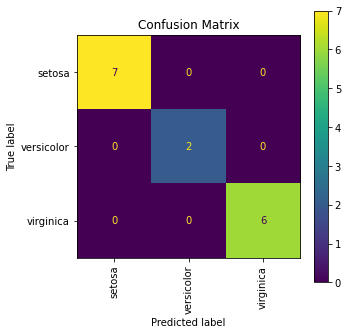

------------------- Iteração 1 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


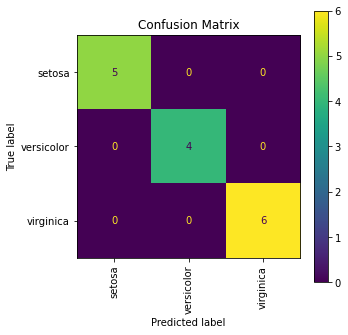

------------------- Iteração 2 -------------------


,Metrics
Recall,0.933333
Precision,0.941667
F1-score,0.930794


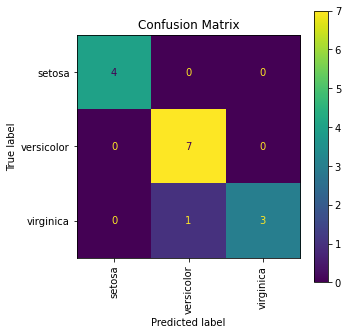

------------------- Iteração 3 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


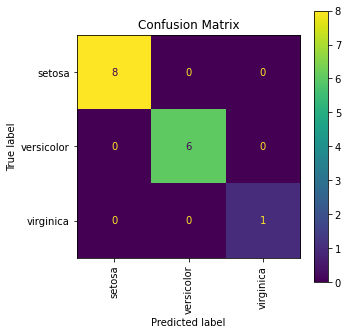

------------------- Iteração 4 -------------------


,Metrics
Recall,0.933333
Precision,0.946667
F1-score,0.935076


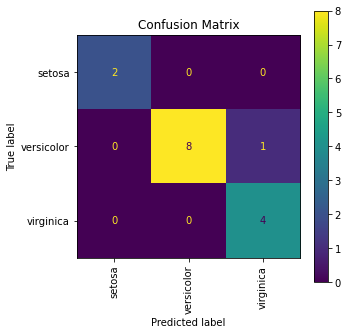

------------------- Iteração 5 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


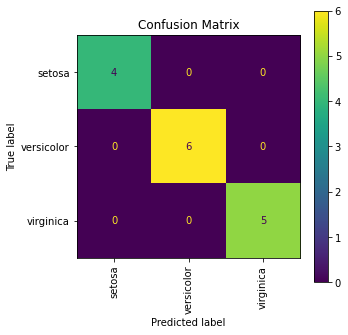

------------------- Iteração 6 -------------------


,Metrics
Recall,0.933333
Precision,0.942857
F1-score,0.932194


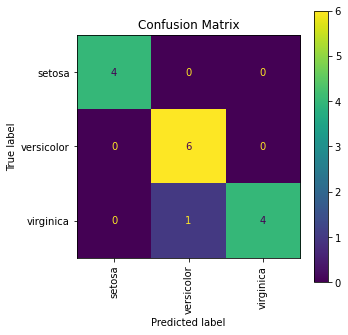

------------------- Iteração 7 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


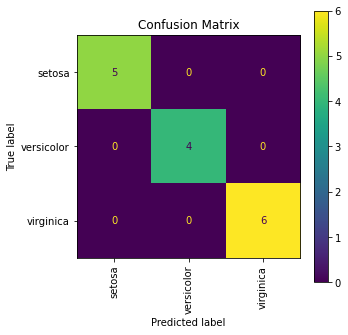

------------------- Iteração 8 -------------------


,Metrics
Recall,0.933333
Precision,0.946667
F1-score,0.933333


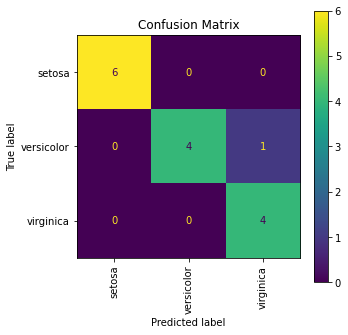

------------------- Iteração 9 -------------------


,Metrics
Recall,0.866667
Precision,0.866667
F1-score,0.866667


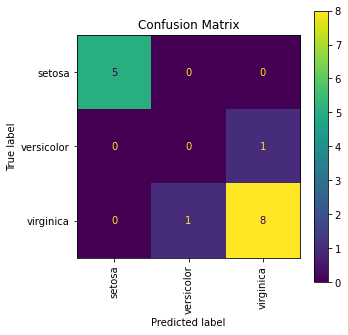

In [15]:
def CV_211(x, y, n_splits, labels, k):
    kf = k_fold(x, y, n_splits)

    count = 0
    for info in kf:
        print("------------------- Iteração " + str(count) + " -------------------")

        neigh = K_neighbors_classifier(info['TRAIN'][0], info['TRAIN'][1], k)
        pred = neigh.predict(info['TEST'][0])
        true = info['TEST'][1]

        cm, rs, ps, f1 = metrics(true, pred)

        mais_bonito(cm, rs, ps, f1, labels)

        count += 1

CV_211(data, target, 10, iris["target_names"], 1)

### 2.1.2. k na gama {1, 3, 5, ...,15}

In [16]:
_k = np.arange(1, 16, 2)

display(_k)

array([ 1,  3,  5,  7,  9, 11, 13, 15])

### 2.1.2. Train-only

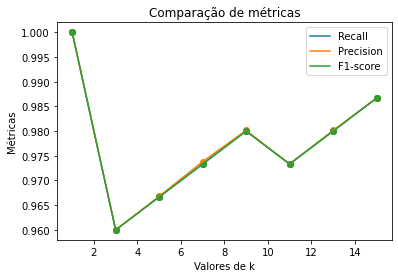

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


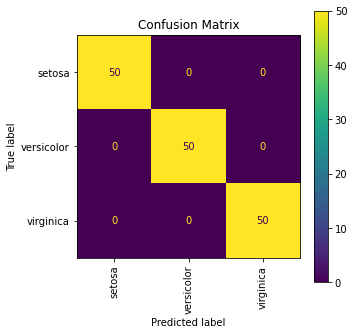

In [17]:
def TO_212(x, y, metr):
    for k in _k:
        neigh = K_neighbors_classifier(x, y, k)
        pred = neigh.predict(x)
        true = y
        cm, rs, ps, f1 = metrics(true, pred)

        metr["Neigh"].append(neigh)
        metr["Recall"].append(rs)
        metr["Precision"].append(ps)
        metr["F1-score"].append(f1)

    return metr

def plot_metricas(metr):
    plt.figure()

    plt.plot(_k, metr["Recall"], label="Recall")
    plt.scatter(_k, metr["Recall"])
    plt.plot(_k, metr["Precision"], label="Precision")
    plt.scatter(_k, metr["Precision"])
    plt.plot(_k, metr["F1-score"], label="F1-score")
    plt.scatter(_k, metr["F1-score"])
    
    
    plt.title("Comparação de métricas")
    plt.xlabel("Valores de k")
    plt.ylabel("Métricas")
    plt.legend()
    plt.show()

def TO_gama(x, y, labels):
    metr = {"Neigh": [], "Recall": [], "Precision": [], "F1-score": []}
    
    new_metr = TO_212(x, y, metr)

    plot_metricas(new_metr)

    pos_k = new_metr["F1-score"].index(max(new_metr["F1-score"]))
    best_k = _k[pos_k]
    print("Best K: " + str(best_k))

    neigh = K_neighbors_classifier(x, y, best_k)
    pred = neigh.predict(x)
    true = y
    cm, rs, ps, f1 = metrics(true, pred)

    mais_bonito(cm, rs, ps, f1, labels)

TO_gama(data, target, iris["target_names"])

### 2.1.2. TVT 40-30-30

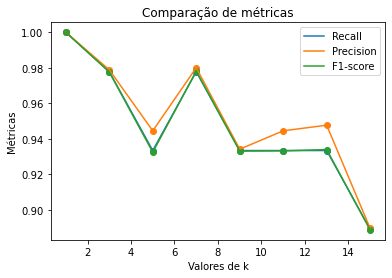

Best K: 1


,Metrics
Recall,0.911111
Precision,0.911111
F1-score,0.911111


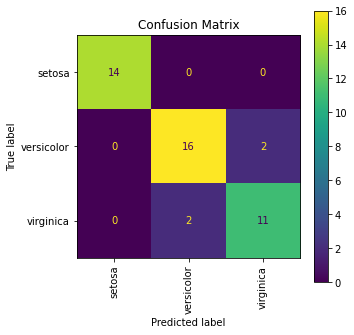

In [18]:
# TODO
# VER O MELHOR K -> FEITO
# PARA O MELHOR K, TESTAR COM O TREINO + VALIDATION JUNTOS, USANDO O TEST COMO PRED


def TVT_212(x, y, metr):
    for k in _k:
        trainValidation = train_validation_test(x, y, 0.4, 0.3)

        neigh = K_neighbors_classifier(trainValidation['TRAIN'][0], trainValidation['TRAIN'][1], k)
        pred = neigh.predict(trainValidation['VALIDATION'][0])
        true = trainValidation['VALIDATION'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        metr["Neigh"].append(neigh)
        metr["Recall"].append(rs)
        metr["Precision"].append(ps)
        metr["F1-score"].append(f1)
    
    return metr

def plot_metricas(metr):
    plt.figure()

    plt.plot(_k, metr["Recall"], label="Recall")
    plt.scatter(_k, metr["Recall"])
    plt.plot(_k, metr["Precision"], label="Precision")
    plt.scatter(_k, metr["Precision"])
    plt.plot(_k, metr["F1-score"], label="F1-score")
    plt.scatter(_k, metr["F1-score"])
    
    plt.title("Comparação de métricas")
    plt.xlabel("Valores de k")
    plt.ylabel("Métricas")
    plt.legend()
    plt.show()

def TVT_gama(x, y, labels, printar=True):
    metr = {"Neigh": [], "Recall": [], "Precision": [], "F1-score": []}
    
    new_metr = TVT_212(x, y, metr)

    plot_metricas(new_metr)

    pos_k = new_metr["F1-score"].index(max(new_metr["F1-score"]))
    best_k = _k[pos_k]
    print("Best K: " + str(best_k))

    trainValidation = train_validation_test(x, y, 0.4, 0.3)

    newTrain0 = np.concatenate((trainValidation['TRAIN'][0], trainValidation['VALIDATION'][0]), axis=0)
    newTrain1 = np.concatenate((trainValidation['TRAIN'][1], trainValidation['VALIDATION'][1]), axis=0)

    neigh = K_neighbors_classifier(newTrain0, newTrain1, best_k)
    pred = neigh.predict(trainValidation['TEST'][0])
    true = trainValidation['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)
    if(printar):
        mais_bonito(cm, rs, ps, f1, labels)

TVT_gama(data, target, iris["target_names"])

### 2.1.2. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


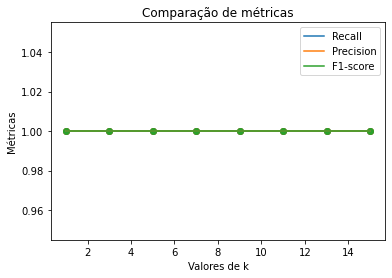

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


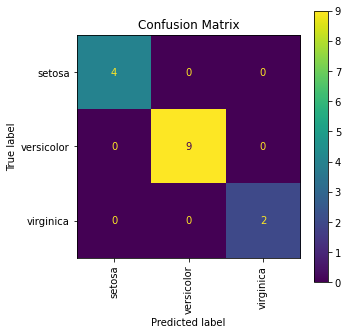

------------------- Iteração 1 -------------------


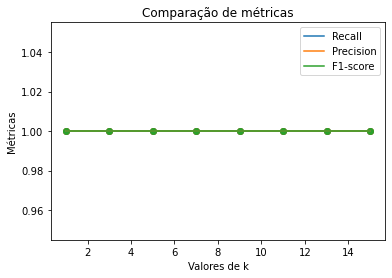

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


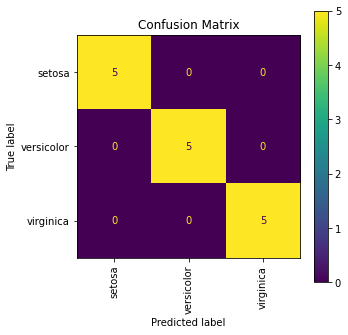

------------------- Iteração 2 -------------------


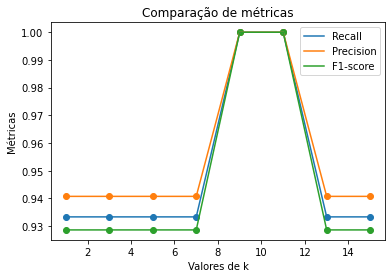

Best K: 9


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


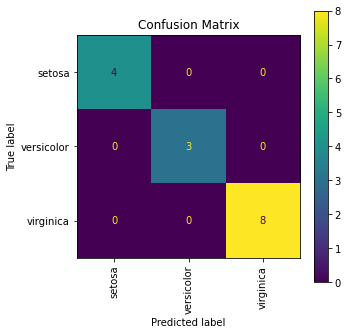

------------------- Iteração 3 -------------------


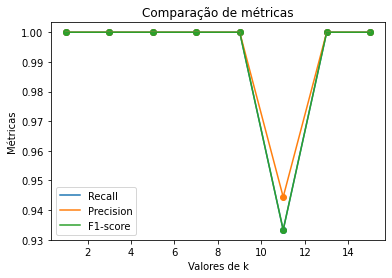

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


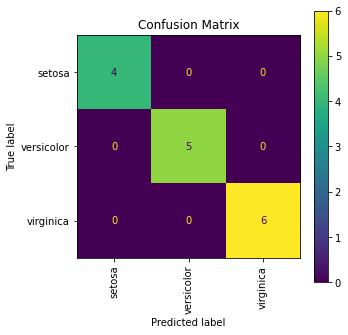

------------------- Iteração 4 -------------------


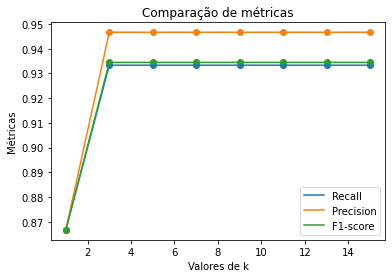

Best K: 3


,Metrics
Recall,0.933333
Precision,0.946667
F1-score,0.934473


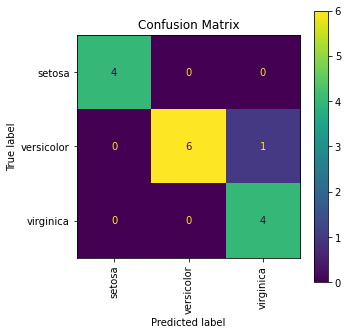

------------------- Iteração 5 -------------------


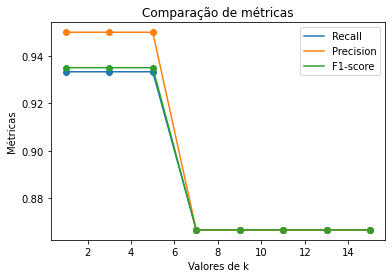

Best K: 1


,Metrics
Recall,0.933333
Precision,0.950000
F1-score,0.935065


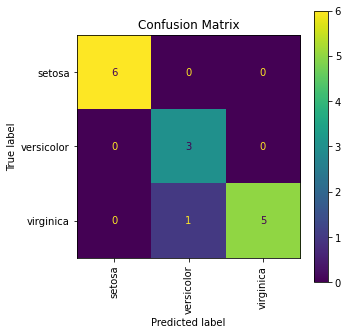

------------------- Iteração 6 -------------------


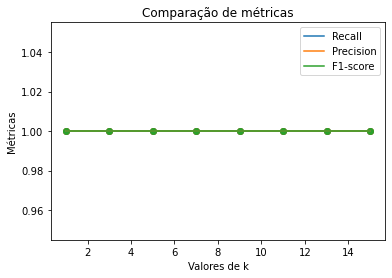

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


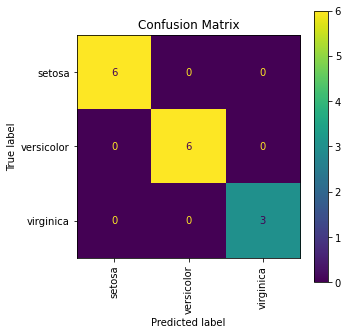

------------------- Iteração 7 -------------------


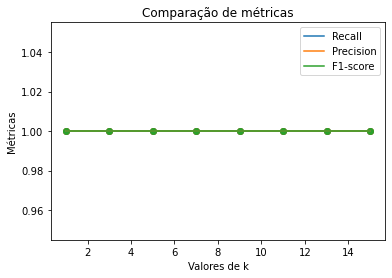

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


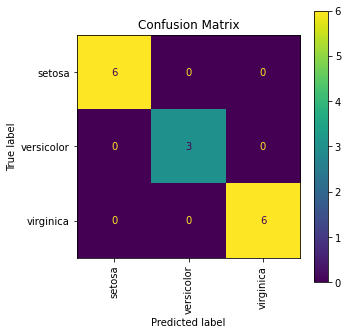

------------------- Iteração 8 -------------------


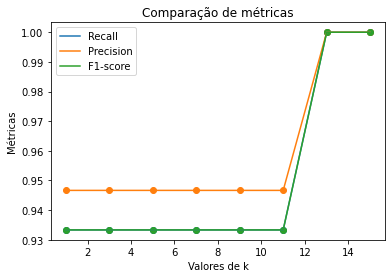

Best K: 13


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


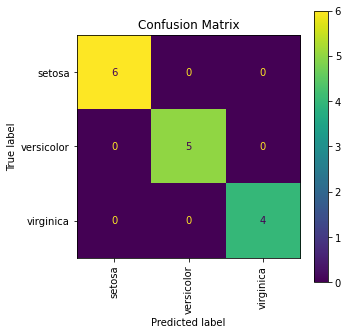

------------------- Iteração 9 -------------------


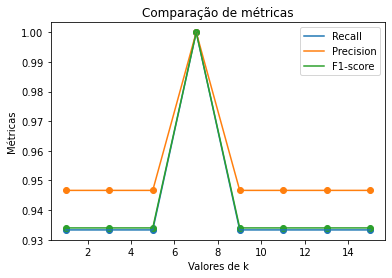

Best K: 7


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


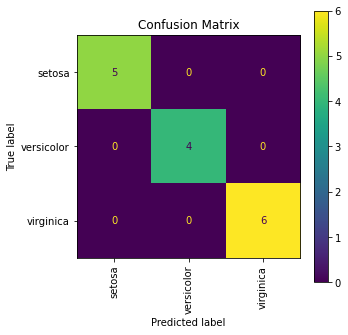

In [19]:
def CV_212(info, metr):
    for k in _k:
        neigh = K_neighbors_classifier(info['TRAIN'][0], info['TRAIN'][1], k)
        pred = neigh.predict(info['TEST'][0])
        true = info['TEST'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        metr["Neigh"].append(neigh)
        metr["Recall"].append(rs)
        metr["Precision"].append(ps)
        metr["F1-score"].append(f1)

    return metr

def plot_metricas(metr):
    plt.figure()

    plt.plot(_k, metr["Recall"], label="Recall")
    plt.scatter(_k, metr["Recall"])
    plt.plot(_k, metr["Precision"], label="Precision")
    plt.scatter(_k, metr["Precision"])
    plt.plot(_k, metr["F1-score"], label="F1-score")
    plt.scatter(_k, metr["F1-score"])
    
    plt.title("Comparação de métricas")
    plt.xlabel("Valores de k")
    plt.ylabel("Métricas")
    plt.legend()
    plt.show()

def CV_gama(x, y, labels):
    
    kf = k_fold(x, y, 10)
    count = 0
    for info in kf:
        metr = {"Neigh": [], "Recall": [], "Precision": [], "F1-score": []}
        print("------------------- Iteração " + str(count) + " -------------------")
        count += 1
        new_metr = CV_212(info, metr)

        plot_metricas(new_metr)

        pos_k = new_metr["F1-score"].index(max(new_metr["F1-score"]))
        best_k = _k[pos_k]
        print("Best K: " + str(best_k))

        neigh = K_neighbors_classifier(info['TRAIN'][0], info['TRAIN'][1], best_k)
        pred = neigh.predict(info['TEST'][0])
        true = info['TEST'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        mais_bonito(cm, rs, ps, f1, labels)

CV_gama(data, target, iris["target_names"])

### 2.1.3. Bias-Variance e Underfitting-Overfitting

<img src="https://cdn.codespeedy.com/wp-content/uploads/2020/05/Bias-vs-variance.png" width="400">

Sendo que Recall define-se como a métrica que indica a quantidade de entidades relevantes devolvidas, percebemos pela imagem acima que está correlacionada com a Bias. Uma Bias baixa dá um Recall elevado (maior precisão).

Já precisão diz respeito à métrica que indica a quantidade de entidades devolvidas que são efetivamente relevantes. Isto relaciona-se com a variância. Uma variância elevada dá um valor de precisão mais baixo.

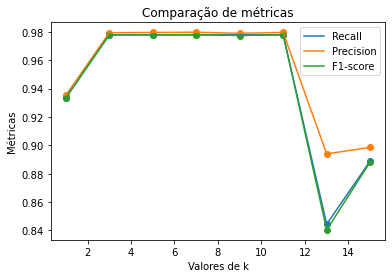

Best K: 7


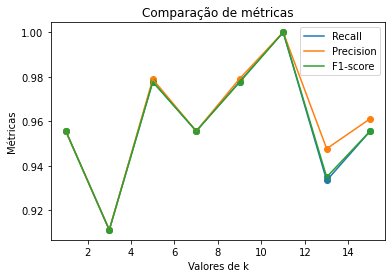

Best K: 11


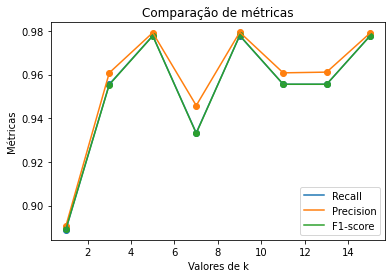

Best K: 9


In [20]:
TVT_gama(data, target, iris["target_names"], printar=False)
TVT_gama(data, target, iris["target_names"], printar=False)
TVT_gama(data, target, iris["target_names"], printar=False)

Analisando os gráficos acima, vemos que a métrica que diz respeito ao Recall está fortemente correlacionada com a Precision. Em todos eles,  para os melhores K, ambas as métricas são elevadas o que nos dá valores de Bias baixa e de Variância elevada. Com isto, os gráficos refletem a imagem seguinte:

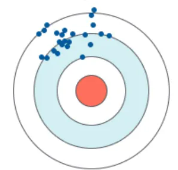

Analisando para o melhor K, é evidente que estamos a considerar valores de Recall e Precision elevados. No entanto, para os outros Ks, muitas vezes os valores de Recall e Precision são baixos. Isto leva a uma Bias e Variância elevadas.

### 2.1.3. Underfitting-Overfitting

https://www.linkedin.com/pulse/100-accuracy-supremacy-imperfection-overfitting-vs-utkarsh-sharma/

Na análise anterior, ficamos a saber que todos os gráficos apresentam Bias baixa e Variância elevada. Posto isto, podemos concluir que têm overfitting.

### 2.2. ReliefF

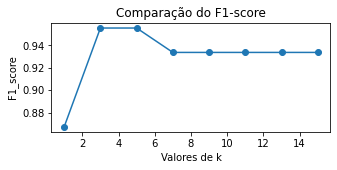

Nr of features: 1
Best K: 3
F1_score: 0.954957264957265
--------------------------------------------------


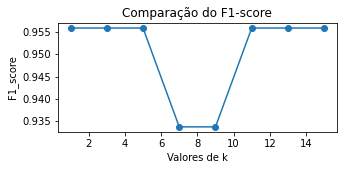

Nr of features: 2
Best K: 1
F1_score: 0.9776511554289331
--------------------------------------------------


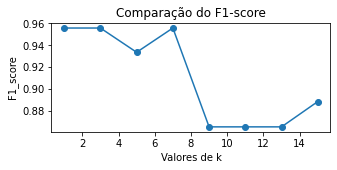

Nr of features: 3
Best K: 1
F1_score: 0.9776511554289331
--------------------------------------------------


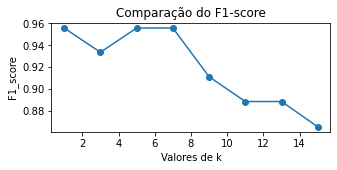

Nr of features: 4
Best K: 1
F1_score: 0.954957264957265
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.867222,0.955556,0.955556,0.933751,0.933751,0.933751,0.933751,0.933751
Nº of features: 2,0.955836,0.955836,0.955836,0.933751,0.933751,0.955836,0.955836,0.955836
Nº of features: 3,0.955836,0.955836,0.933751,0.955836,0.865833,0.865833,0.865833,0.888889
Nº of features: 4,0.955836,0.933751,0.955836,0.955836,0.911481,0.888889,0.888889,0.865833


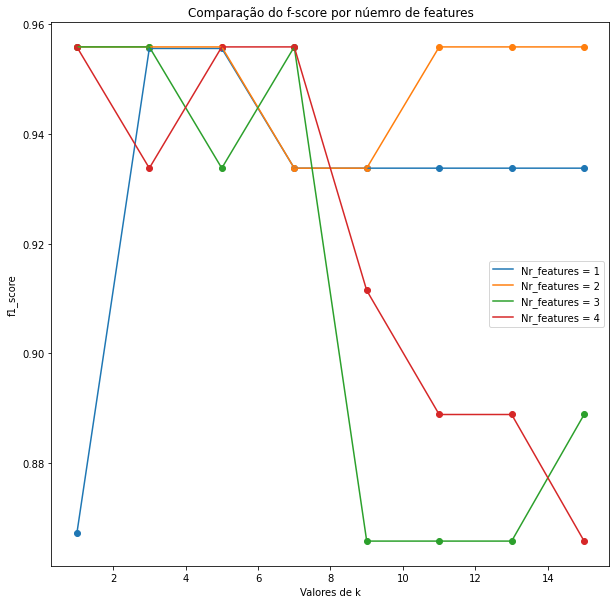

In [21]:
def plot_f1(metr_f1):
    plt.figure(figsize=(5,2))

    plt.plot(_k, metr_f1["F1-score"])
    plt.scatter(_k, metr_f1["F1-score"])
    
    plt.title("Comparação do F1-score")
    plt.xlabel("Valores de k")
    plt.ylabel("F1_score")
    plt.show()

def bestkTVT(metr, feat, xTrain, xValidation, trainValidation, s):
    s += 'Nr of features: ' + str(len(feat)) + '\n'
    print('Nr of features: ' + str(len(feat)))
    pos_k = metr["F1-score"].index(max(metr["F1-score"]))
    best_k = _k[pos_k]
    s += "Best K: " + str(best_k) + '\n'
    print("Best K: " + str(best_k))

    newTrain0 = np.concatenate((xTrain, xValidation), axis=0)
    newTrain1 = np.concatenate((trainValidation['TRAIN'][1], trainValidation['VALIDATION'][1]), axis=0)

    neigh = K_neighbors_classifier(newTrain0, newTrain1, best_k)
    xTest = trainValidation['TEST'][0][:,feat]
    pred = neigh.predict(xTest)
    true = trainValidation['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)

    s += 'F1_score: ' + str(f1) + '\n' + '-'*50 + '\n'
    print('F1_score: ' + str(f1))
    print('-'*50)

    return f1, s

def plot_final(f1_score):
    plt.figure(figsize=(10,10))

    for f in range(len(f1_score)):

        plt.plot(_k, f1_score[f], label="Nr_features = " + str(f+1))
        plt.scatter(_k, f1_score[f])
    
    plt.title("Comparação do f-score por núemro de features")
    plt.xlabel("Valores de k")
    plt.ylabel("f1_score")
    plt.legend()
    plt.show()

def repeatTVT(x, y, featselec, num = 4):

    trainValidation = train_validation_test(x, y, 0.4, 0.3)

    f1_score = []
    f1_score_elbow = []
    str_print = ''

    for f in range(num):
        metr = {"F1-score": []}
        feat = featselec[:(f+1)]
        xTrain = trainValidation['TRAIN'][0][:,feat]
        xValidation = trainValidation['VALIDATION'][0][:,feat]

        for k in _k:
            neigh = K_neighbors_classifier(xTrain, trainValidation['TRAIN'][1], k)
            pred = neigh.predict(xValidation)
            true = trainValidation['VALIDATION'][1]
            cm, rs, ps, f1 = metrics(true, pred)

            metr["F1-score"].append(f1)
        f1_score.append(metr["F1-score"])

        #------------Plot F1-Score--------------------------
        plot_f1(metr)

        #------------Best k--------------------------
        aux, str_print = bestkTVT(metr, feat, xTrain, xValidation, trainValidation, str_print)
        f1_score_elbow.append(aux)

    label = ['Nº of features: ' + str(i+1) for i in range(len(featselec))]
    col = ['k=' + str(i) for i in _k]
    df = pd.DataFrame(f1_score, columns = col, index = label)
    display(df)
    plot_final(f1_score)

    return f1_score_elbow, df, str_print
        

f1_score_elbow, df223, str_print = repeatTVT(data, target, reliefF(data, target))

### 2.2.2 Elbow graph

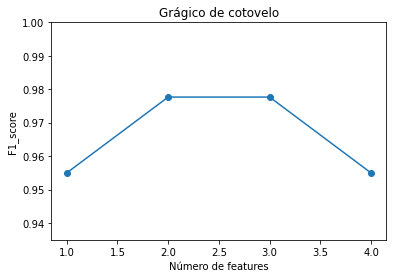

In [22]:
def elbowGraph(lista_f1, num):
    index = np.arange(1,num)

    #plt.figure(figsize=(5,2))
    plt.ylim(min(lista_f1)-0.02,1)

    plt.plot(index, lista_f1)
    plt.scatter(index, lista_f1)
    
    plt.title("Grágico de cotovelo")
    plt.xlabel("Número de features")
    plt.ylabel("F1_score")
    plt.show()

elbowGraph(f1_score_elbow, 5)

### 2.2.3. Validation set results

In [23]:
display(df223)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.867222,0.955556,0.955556,0.933751,0.933751,0.933751,0.933751,0.933751
Nº of features: 2,0.955836,0.955836,0.955836,0.933751,0.933751,0.955836,0.955836,0.955836
Nº of features: 3,0.955836,0.955836,0.933751,0.955836,0.865833,0.865833,0.865833,0.888889
Nº of features: 4,0.955836,0.933751,0.955836,0.955836,0.911481,0.888889,0.888889,0.865833


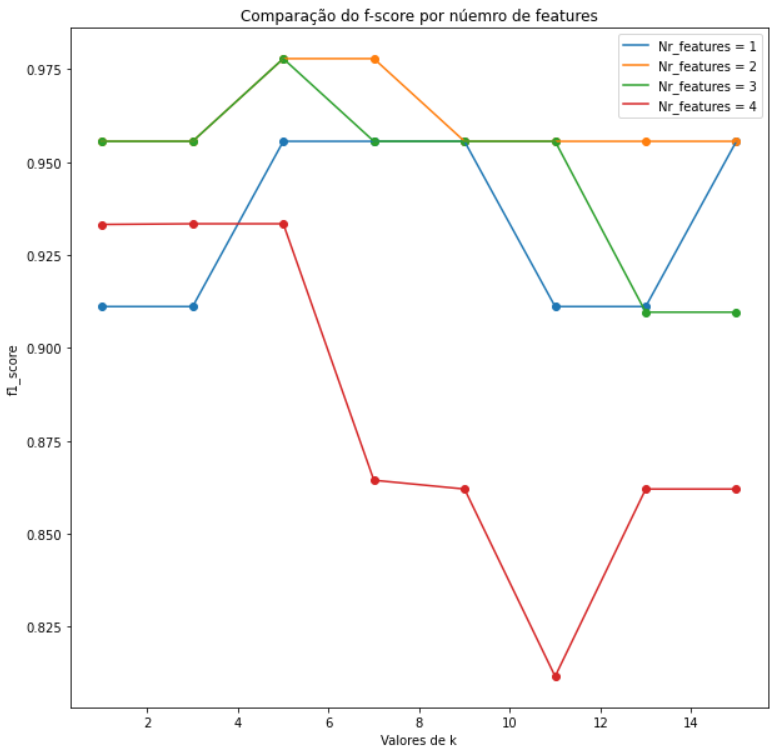

O gráfico acima deriva da evolução do f1-score com a variação do K, para diversas quantidades de features (alínea 2.1.1.).

- **Bias-Variance:**
    - Tal como analisamos anteriormente, a Bias e a Variance relacionam-se com a Precision e a Recall. Deste modo, como a f1-score é uma métrica que advém da relação entre as duas métricas citadas, não conseguimos concluir nada em relação a este dilema. Para isso, necessitavamos de ter gráficos com a Bias e a Variance.<br><br>
- **Underfitting-Overfitting:**
    - De igual modo, necessitaríamos de gráficos com a Bias e a Variance para analisar esta questão. 

### 2.2.4. Test set results

In [24]:
print(str_print)

Nr of features: 1
Best K: 3
F1_score: 0.954957264957265
--------------------------------------------------
Nr of features: 2
Best K: 1
F1_score: 0.9776511554289331
--------------------------------------------------
Nr of features: 3
Best K: 1
F1_score: 0.9776511554289331
--------------------------------------------------
Nr of features: 4
Best K: 1
F1_score: 0.954957264957265
--------------------------------------------------



https://stackoverflow.com/questions/61519021/can-test-accuracy-be-greater-than-validation-accuracy

Comparando os resultados do modelo ideal no conjunto de teste com os do conjunto de validação, percebemos que a f1-score tem valores mais elevados no conjunto de validação. Isto explica-se uma vez que o conjunto de validação serve para afinar os parâmetros do modelo. Deste modo, os erros com a validação decresce, ao contrário do conjunto de teste.

### 2.3. Fisher Score

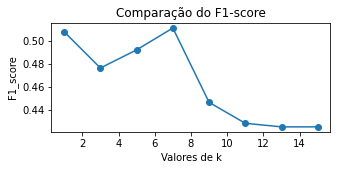

Nr of features: 1
Best K: 7
F1_score: 0.6143888888888889
--------------------------------------------------


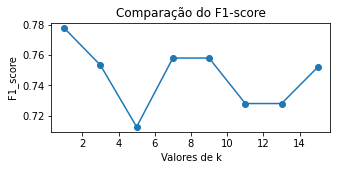

Nr of features: 2
Best K: 1
F1_score: 0.6666666666666666
--------------------------------------------------


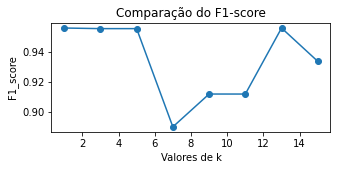

Nr of features: 3
Best K: 1
F1_score: 0.9335818577197889
--------------------------------------------------


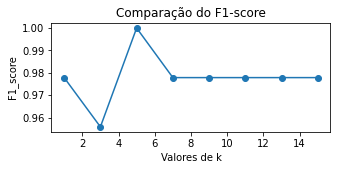

Nr of features: 4
Best K: 5
F1_score: 0.9776511554289331
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.507939,0.476440,0.492226,0.511213,0.446561,0.428331,0.425253,0.425253
Nº of features: 2,0.777778,0.753350,0.712762,0.758025,0.758025,0.728098,0.728098,0.752074
Nº of features: 3,0.955958,0.955556,0.955556,0.890011,0.911916,0.911905,0.955958,0.933714
Nº of features: 4,0.977905,0.955958,1.000000,0.977905,0.977905,0.977905,0.977905,0.977905


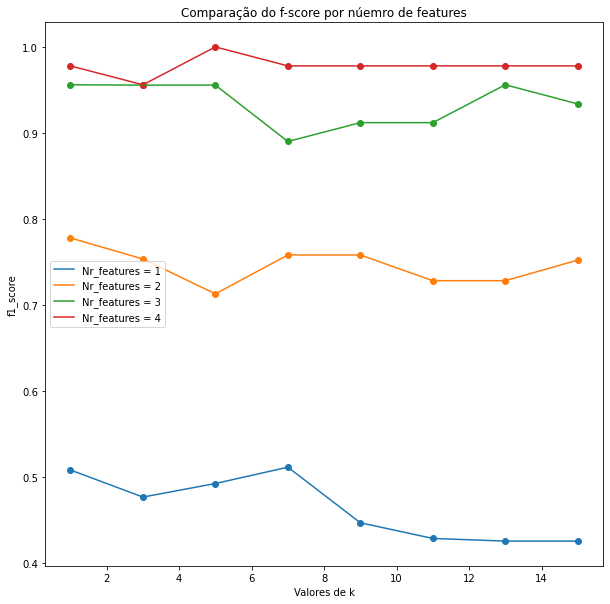

In [25]:
score = fisherScore(data, target)

f1_score_elbow, df223, str_print = repeatTVT(data, target, score)


### 2.3.2. Elbow Graph

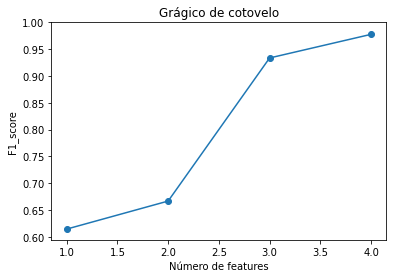

In [26]:
elbowGraph(f1_score_elbow, 5)

### 2.3.3. Validation set results

In [27]:
display(df223)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.507939,0.476440,0.492226,0.511213,0.446561,0.428331,0.425253,0.425253
Nº of features: 2,0.777778,0.753350,0.712762,0.758025,0.758025,0.728098,0.728098,0.752074
Nº of features: 3,0.955958,0.955556,0.955556,0.890011,0.911916,0.911905,0.955958,0.933714
Nº of features: 4,0.977905,0.955958,1.000000,0.977905,0.977905,0.977905,0.977905,0.977905


### 2.3.4. Test set results

In [28]:
print(str_print)

Nr of features: 1
Best K: 7
F1_score: 0.6143888888888889
--------------------------------------------------
Nr of features: 2
Best K: 1
F1_score: 0.6666666666666666
--------------------------------------------------
Nr of features: 3
Best K: 1
F1_score: 0.9335818577197889
--------------------------------------------------
Nr of features: 4
Best K: 5
F1_score: 0.9776511554289331
--------------------------------------------------



### 2.4. Class imbalance

 'target_names': array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [29]:
irisDF = pd.DataFrame(iris.data, columns=iris["feature_names"])
irisDF["target"] = iris["target"]
setosa = irisDF[irisDF["target"] == 0]
versicolor = irisDF[irisDF["target"] == 1].sample(30)
virginica = irisDF[irisDF["target"] == 2].sample(10)
new_iris = pd.concat([setosa, versicolor, virginica], axis=0)
new_iris.groupby("target").count()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
target,,,,
0,50,50,50,50
1,30,30,30,30
2,10,10,10,10


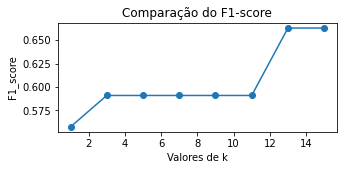

Nr of features: 1
Best K: 13
F1_score: 0.8262108262108263
--------------------------------------------------


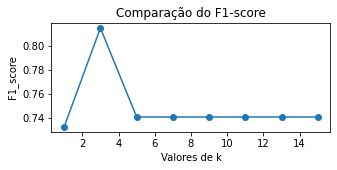

Nr of features: 2
Best K: 3
F1_score: 0.8950617283950616
--------------------------------------------------


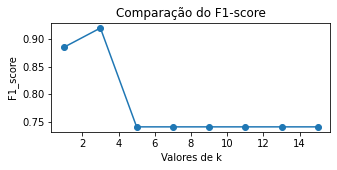

Nr of features: 3
Best K: 3
F1_score: 0.9584736251402918
--------------------------------------------------


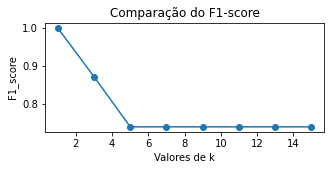

Nr of features: 4
Best K: 1
F1_score: 1.0
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.557407,0.591000,0.591000,0.591000,0.591000,0.591000,0.663139,0.663139
Nº of features: 2,0.732510,0.814815,0.740741,0.740741,0.740741,0.740741,0.740741,0.740741
Nº of features: 3,0.885362,0.920034,0.740741,0.740741,0.740741,0.740741,0.740741,0.740741
Nº of features: 4,1.000000,0.872326,0.740741,0.740741,0.740741,0.740741,0.740741,0.740741


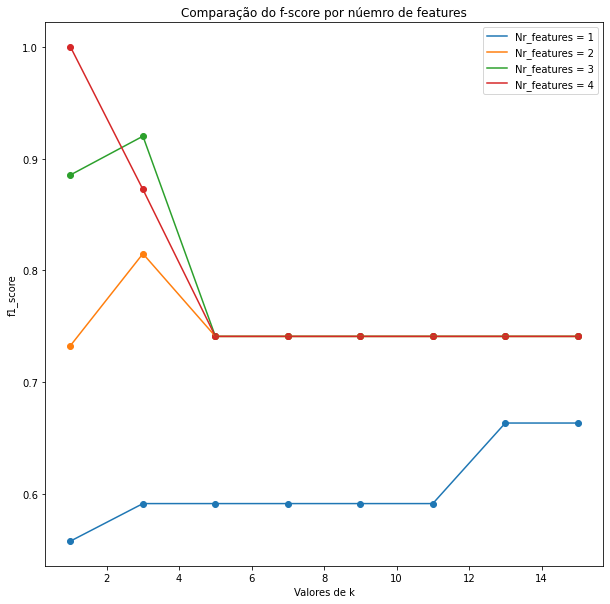

In [30]:
aux_data = np.array(new_iris.drop(columns=["target"]))
aux_target = np.array(new_iris["target"])

score = fisherScore(aux_data, aux_target)

newIris_elbow, df224, str_print = repeatTVT(aux_data, aux_target, score)

### 2.4.2. Elbow Graph

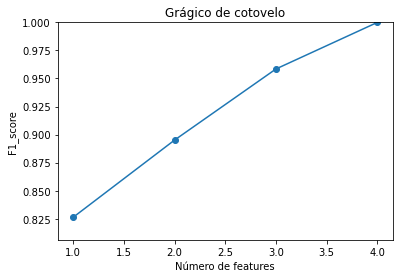

In [31]:
elbowGraph(newIris_elbow, 5)

### 2.4.3. Validation set results

In [32]:
display(df224)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.557407,0.591000,0.591000,0.591000,0.591000,0.591000,0.663139,0.663139
Nº of features: 2,0.732510,0.814815,0.740741,0.740741,0.740741,0.740741,0.740741,0.740741
Nº of features: 3,0.885362,0.920034,0.740741,0.740741,0.740741,0.740741,0.740741,0.740741
Nº of features: 4,1.000000,0.872326,0.740741,0.740741,0.740741,0.740741,0.740741,0.740741


### 2.4.4. Test set results

In [33]:
print(str_print)

Nr of features: 1
Best K: 13
F1_score: 0.8262108262108263
--------------------------------------------------
Nr of features: 2
Best K: 3
F1_score: 0.8950617283950616
--------------------------------------------------
Nr of features: 3
Best K: 3
F1_score: 0.9584736251402918
--------------------------------------------------
Nr of features: 4
Best K: 1
F1_score: 1.0
--------------------------------------------------



Tal como era expectável, os valores provenientes do desbalanceamento são inferiores (piores), uma vez que o dataset não está balanceado. O  não balanceamento leva a que, tendencialmente, o modelo classifique mais entidades como aquelas que constam mais no dataset de treino. Com isto, algumas entidades são classificadas erradamente, levando a que a métrica da f1-score diminua. 

### 3. ReliefF for dataset of human activity

In [34]:
new_data = pd.read_csv("features.csv")

new_target = np.array(new_data["Label"])
feature_data = np.array(new_data.drop(columns = ["Label"]))

### 3.1.1. Train-only

,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


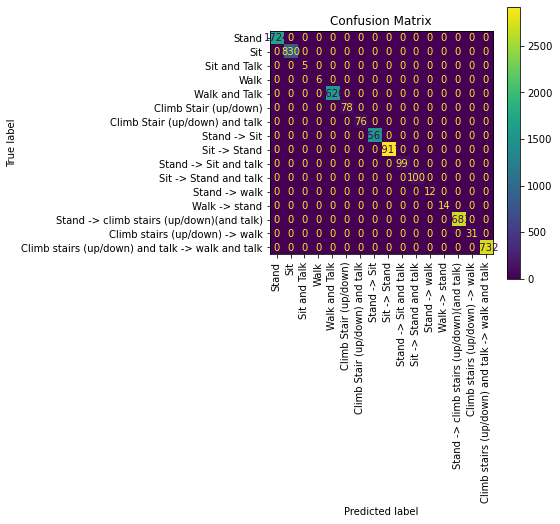

In [35]:
TO_211(feature_data, new_target, activities, 1)

### 3.1.1. TT 70-30

,Metrics
Recall,0.711295
Precision,0.711985
F1-score,0.711371


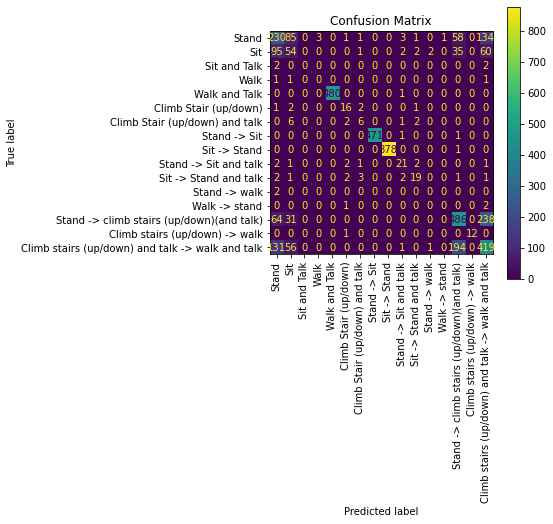

In [36]:
TT_211(feature_data, new_target, activities, 1)

### 3.1.1. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


,Metrics
Recall,0.719117
Precision,0.725970
F1-score,0.721761


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,83,24,1,0,0,0,0,0,0,1,1,0,14,0,48
1,30,22,0,0,0,1,0,0,1,0,0,0,11,0,14
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,160,0,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,6,1,0,0,0,0,0,1,0,0,1
5,2,2,0,0,1,4,0,0,1,0,0,0,0,0,1
6,0,0,0,0,0,0,142,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,284,0,0,0,0,0,0,0
8,2,0,0,0,0,0,0,0,3,0,0,2,0,0,0
9,1,0,0,0,1,1,0,0,1,3,0,0,0,0,0


------------------- Iteração 1 -------------------


,Metrics
Recall,0.726018
Precision,0.723536
F1-score,0.724188


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,86,19,0,0,1,1,0,0,2,0,0,0,20,0,57
1,25,19,0,0,0,0,0,0,0,0,0,0,11,0,23
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,173,0,0,1,0,0,0,0,0,0,0,0
4,0,2,0,0,6,0,0,0,0,1,0,0,0,0,0
5,0,1,0,0,2,7,0,0,1,1,0,0,0,0,0
6,0,0,0,0,0,0,145,0,1,0,0,0,0,0,0
7,0,0,0,0,0,0,0,310,0,0,0,0,1,0,0
8,0,0,0,0,1,0,0,0,6,1,0,0,0,0,0
9,1,1,0,0,0,1,0,0,0,8,0,1,0,0,0


------------------- Iteração 2 -------------------


,Metrics
Recall,0.722567
Precision,0.720503
F1-score,0.720740


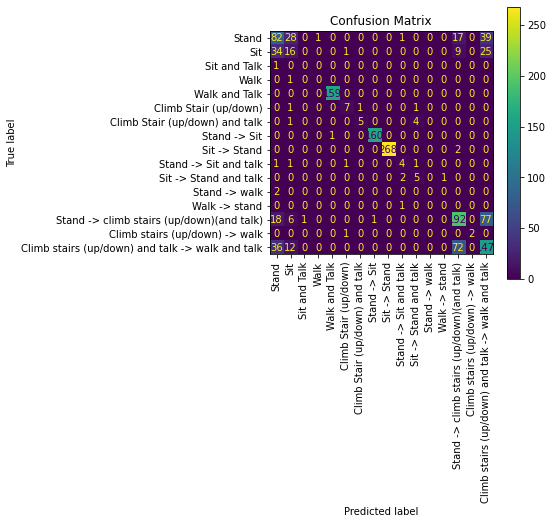

------------------- Iteração 3 -------------------


,Metrics
Recall,0.718427
Precision,0.716015
F1-score,0.716877


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,86,22,0,0,0,0,0,0,1,0,0,20,49
1,33,10,1,0,0,0,0,0,3,1,0,7,17
2,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,157,0,0,0,0,0,0,0,0,0
4,1,0,0,0,5,0,0,0,0,1,0,0,0
5,0,0,0,0,0,5,0,0,0,0,0,0,0
6,0,0,0,0,0,0,167,0,0,0,0,0,0
7,0,0,0,0,0,0,0,296,0,0,0,1,0
8,1,0,0,0,0,0,0,0,5,2,0,0,0
9,0,0,0,0,1,1,0,0,2,5,0,0,0


------------------- Iteração 4 -------------------


,Metrics
Recall,0.705314
Precision,0.705069
F1-score,0.704628


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,101,31,0,1,0,0,0,0,0,0,0,15,0,44
1,34,22,1,0,0,2,1,0,0,0,1,10,0,20
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,142,0,0,0,0,0,0,0,0,0
5,1,1,0,0,0,2,2,0,0,0,0,0,0,0
6,0,1,0,0,0,0,6,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,136,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,279,0,0,1,0,0
9,0,1,0,0,0,1,0,0,0,11,0,0,0,0


------------------- Iteração 5 -------------------


,Metrics
Recall,0.737750
Precision,0.737296
F1-score,0.736267


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,73,18,1,0,0,0,0,0,0,1,0,0,20,0,42
1,31,20,0,0,0,1,0,0,1,0,0,0,8,0,29
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,169,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,5,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,164,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,312,0,0,0,0,2,0,0
8,0,0,0,0,0,0,0,0,6,1,0,0,0,0,0
9,1,0,0,0,0,1,0,0,3,9,0,0,0,0,0


------------------- Iteração 6 -------------------


,Metrics
Recall,0.721187
Precision,0.724744
F1-score,0.722448


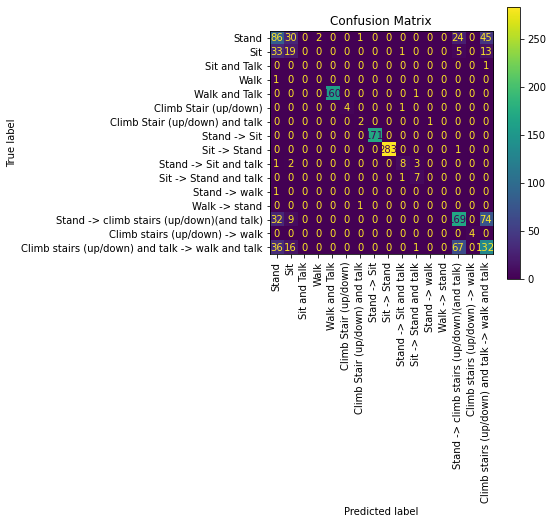

------------------- Iteração 7 -------------------


,Metrics
Recall,0.710835
Precision,0.708645
F1-score,0.708380


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,86,17,0,0,0,0,0,0,0,0,1,31,0,45
1,38,18,0,1,1,0,0,0,0,0,0,14,0,21
2,0,0,159,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,4,1,0,0,0,0,0,0,0,0,0
4,0,1,0,3,6,0,0,1,1,0,0,0,0,0
5,0,0,0,0,0,158,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,290,0,0,0,0,0,0,0
7,0,1,0,1,0,1,0,7,1,0,0,0,0,1
8,2,0,0,2,1,0,0,1,8,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,1,0,0,1


------------------- Iteração 8 -------------------


,Metrics
Recall,0.735497
Precision,0.739603
F1-score,0.735617


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,73,20,0,0,0,0,0,0,0,0,0,0,15,0,28
1,22,23,0,0,1,0,0,0,1,0,1,0,13,0,16
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,175,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,9,2,0,0,0,0,0,0,0,0,0
5,1,2,0,0,0,5,0,0,1,0,0,0,0,0,0
6,0,0,0,0,0,0,175,0,0,0,0,0,2,0,0
7,0,0,0,0,0,0,0,286,0,0,0,0,1,0,0
8,0,1,0,0,1,1,0,0,5,0,0,0,0,0,1
9,1,0,0,0,2,0,0,0,1,3,0,0,0,0,2


------------------- Iteração 9 -------------------


,Metrics
Recall,0.720304
Precision,0.718216
F1-score,0.717461


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,82,21,0,1,1,0,0,1,0,2,0,19,0,42
1,36,19,0,0,0,0,0,1,0,0,0,15,0,23
2,0,0,163,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,6,0,0,0,0,0,0,0,0,0,0
4,2,0,0,1,1,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,139,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,300,0,0,0,0,0,0,0
7,1,2,0,0,2,0,0,6,1,0,0,0,0,1
8,0,2,0,0,3,0,0,0,5,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
CV_211(feature_data, new_target, 10, activities, 1)

### 3.1.2. Train-only

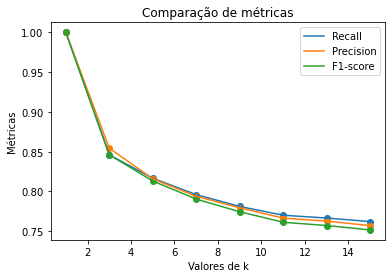

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


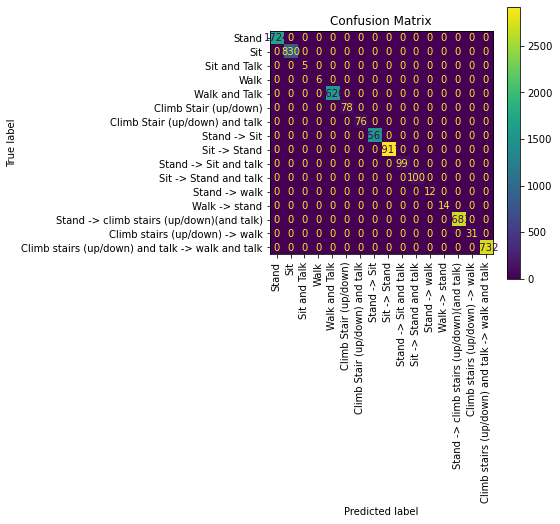

In [38]:
TO_gama(feature_data, new_target, activities)

### 3.1.2. TVT 40-30-30

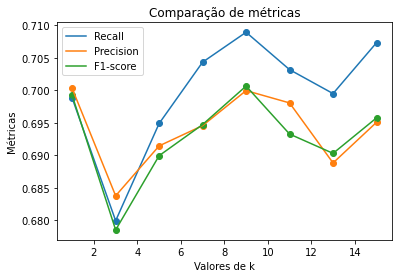

Best K: 9


,Metrics
Recall,0.704394
Precision,0.696733
F1-score,0.695996


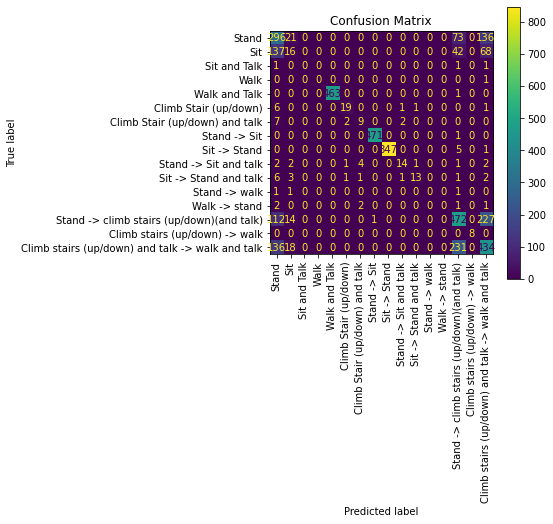

In [39]:
TVT_gama(feature_data, new_target, activities)

### 3.1.2. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


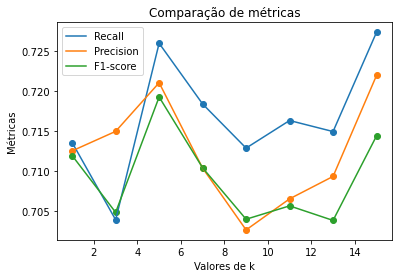

Best K: 5


,Metrics
Recall,0.726018
Precision,0.721081
F1-score,0.719299


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,94,10,0,0,0,0,0,0,0,0,0,18,0,36
1,39,12,0,0,0,0,0,1,0,0,0,13,0,27
2,0,0,169,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,10,0,0,0,0,0,0,0,0,0,0
4,0,2,0,0,4,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,148,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,306,0,0,0,0,1,0,0
7,2,2,0,1,0,0,0,4,0,0,0,0,0,0
8,0,1,0,0,1,0,0,0,5,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,0,0,0,0


------------------- Iteração 1 -------------------


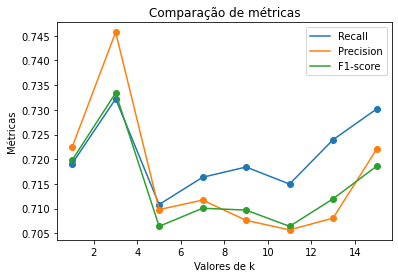

Best K: 3


,Metrics
Recall,0.732229
Precision,0.745708
F1-score,0.733412


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,89,23,0,0,0,0,0,0,0,0,0,7,0,27
1,38,15,0,0,0,0,0,0,1,0,0,8,0,20
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,175,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,7,0,0,0,0,0,0,0,0,0
5,2,1,0,0,2,6,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,172,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,269,0,0,0,3,0,0
8,3,5,0,0,0,1,0,0,2,1,0,0,0,1
9,1,1,0,0,0,0,0,0,0,5,0,0,0,1


------------------- Iteração 2 -------------------


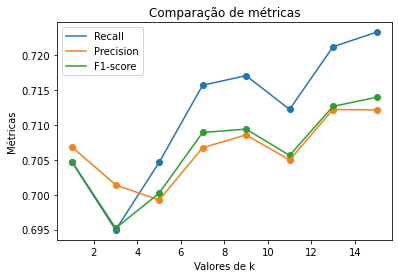

Best K: 15


,Metrics
Recall,0.723257
Precision,0.712131
F1-score,0.713948


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,98,8,0,0,1,0,0,0,0,0,0,0,25,0,43
1,39,5,0,0,1,0,0,0,0,1,0,0,8,0,27
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,149,0,0,0,0,0,0,0,0,1,0,0
4,3,0,0,0,8,0,0,0,1,0,0,0,0,0,0
5,2,1,0,0,0,4,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,145,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,284,0,0,0,0,2,0,0
8,1,1,0,0,0,0,0,0,9,0,0,0,0,0,0
9,3,1,0,0,1,1,0,0,1,3,0,0,0,0,0


------------------- Iteração 3 -------------------


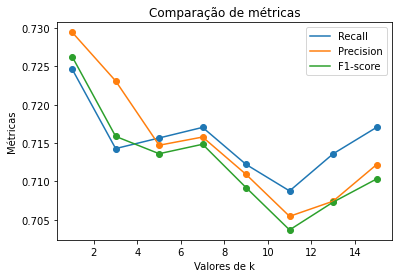

Best K: 1


,Metrics
Recall,0.724638
Precision,0.729446
F1-score,0.726268


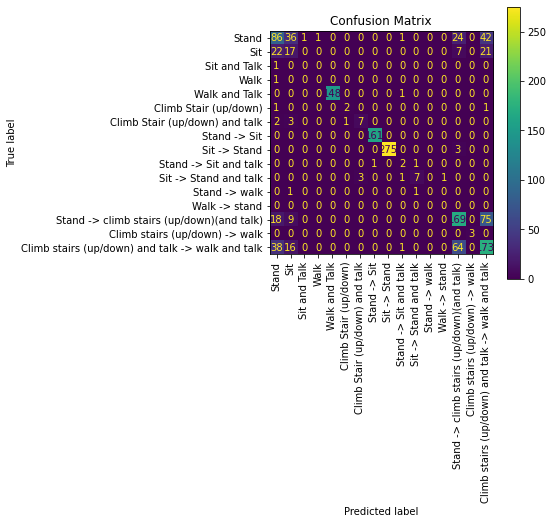

------------------- Iteração 4 -------------------


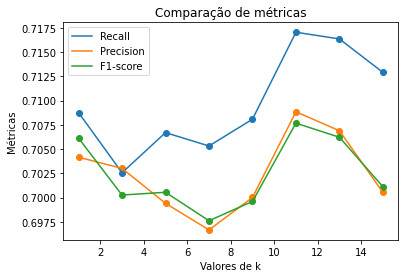

Best K: 11


,Metrics
Recall,0.717046
Precision,0.708844
F1-score,0.707668


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,98,9,0,0,0,0,0,0,0,0,0,16,0,60
1,33,8,0,0,0,0,0,0,0,0,0,20,0,27
2,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,163,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,7,2,0,0,0,0,0,0,0,0
5,0,0,0,0,0,6,0,0,0,2,0,0,0,1
6,0,0,0,0,0,0,157,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,284,0,0,0,0,0,0
8,0,1,0,0,1,3,0,0,6,1,0,1,0,0
9,2,0,0,0,0,0,0,0,0,6,0,0,0,1


------------------- Iteração 5 -------------------


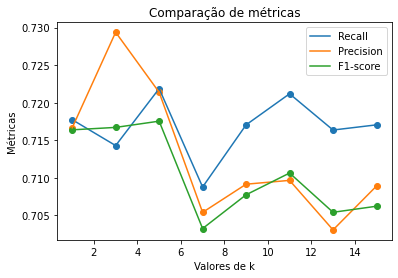

Best K: 5


,Metrics
Recall,0.721877
Precision,0.721388
F1-score,0.717538


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,91,16,0,0,0,0,0,0,0,0,0,19,0,37
1,51,10,0,0,0,0,0,0,0,0,0,12,0,14
2,0,0,169,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,4,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,3,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,152,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,291,0,0,0,0,3,0,0
7,0,0,0,1,0,0,0,6,0,0,0,1,0,1
8,3,1,0,1,2,0,0,0,5,0,0,1,0,0
9,1,0,0,0,0,0,0,0,0,0,0,0,0,0


------------------- Iteração 6 -------------------


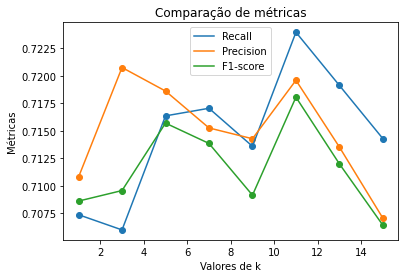

Best K: 11


,Metrics
Recall,0.723948
Precision,0.719589
F1-score,0.718053


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,85,9,0,0,0,0,0,0,0,0,0,16,0,55
1,31,8,0,0,0,0,0,0,0,0,0,13,0,22
2,0,0,173,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,3,0,0,0,0,0,0,0,0,0,1
4,3,0,0,3,3,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,151,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,294,0,0,0,0,2,0,0
7,1,0,0,0,2,0,0,5,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,7,0,0,1,0,0
9,0,0,0,1,0,0,0,0,0,0,0,0,0,1


------------------- Iteração 7 -------------------


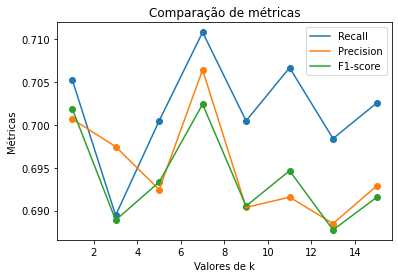

Best K: 7


,Metrics
Recall,0.710835
Precision,0.706443
F1-score,0.702427


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,99,5,0,0,0,0,0,0,0,0,0,24,0,46
1,42,9,0,0,0,0,0,0,0,0,0,17,0,22
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,152,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,3,2,0,0,1,1,0,0,0,0
5,0,0,0,0,0,6,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,152,0,1,0,0,1,0,0
7,0,0,0,0,0,0,0,294,0,0,0,0,0,0
8,1,1,0,0,1,0,0,0,5,2,0,0,0,0
9,0,0,0,0,1,1,0,0,2,3,0,0,0,1


------------------- Iteração 8 -------------------


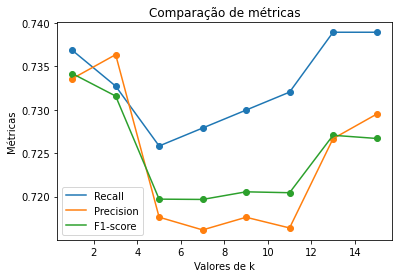

Best K: 1


,Metrics
Recall,0.736878
Precision,0.733587
F1-score,0.734189


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,87,26,1,0,0,0,0,0,0,0,0,0,14,0,54
1,33,16,0,0,0,1,1,0,0,1,0,0,9,0,24
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2
4,0,0,0,0,152,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,7,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0
7,0,0,0,0,0,0,0,164,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,308,0,0,0,0,0,0
9,1,0,0,0,0,1,0,1,0,8,0,0,0,0,0


------------------- Iteração 9 -------------------


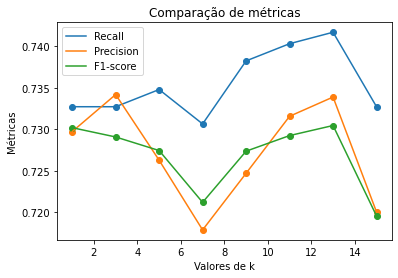

Best K: 13


,Metrics
Recall,0.741713
Precision,0.733901
F1-score,0.730470


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,110,4,0,0,1,0,0,0,0,0,0,0,22,0,50
1,40,5,0,0,0,0,0,0,1,0,0,0,10,0,28
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,168,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,155,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,296,0,0,0,0,2,0,0
8,0,1,0,0,0,0,0,0,10,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,2,9,0,0,0,0,0


In [40]:
CV_gama(feature_data, new_target, activities)

### 3.2. ReliefF

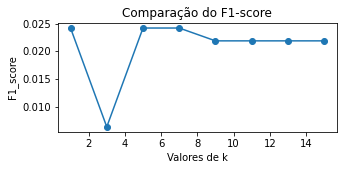

Nr of features: 1
Best K: 1
F1_score: 0.023640575076990585
--------------------------------------------------


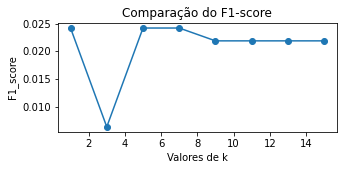

Nr of features: 2
Best K: 1
F1_score: 0.023640575076990585
--------------------------------------------------


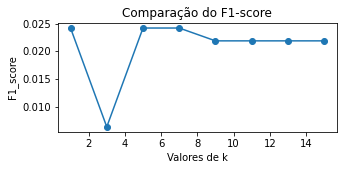

Nr of features: 3
Best K: 1
F1_score: 0.023640575076990585
--------------------------------------------------


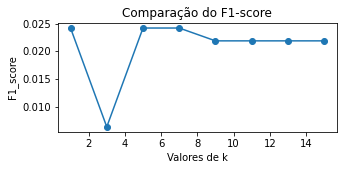

Nr of features: 4
Best K: 1
F1_score: 0.023640575076990585
--------------------------------------------------


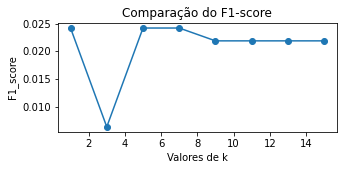

Nr of features: 5
Best K: 1
F1_score: 0.023640575076990585
--------------------------------------------------


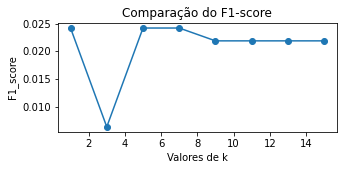

Nr of features: 6
Best K: 1
F1_score: 0.023640575076990585
--------------------------------------------------


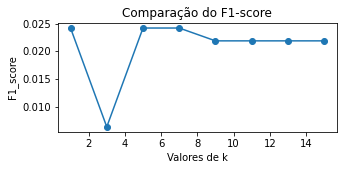

Nr of features: 7
Best K: 1
F1_score: 0.023640575076990585
--------------------------------------------------


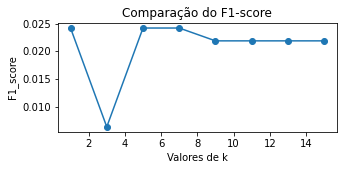

Nr of features: 8
Best K: 1
F1_score: 0.023640575076990585
--------------------------------------------------


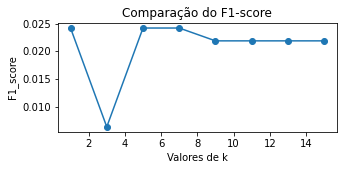

Nr of features: 9
Best K: 1
F1_score: 0.023640575076990585
--------------------------------------------------


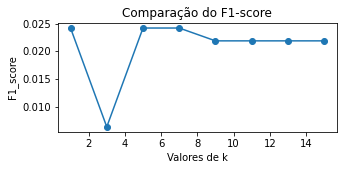

Nr of features: 10
Best K: 1
F1_score: 0.023640575076990585
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.024193,0.006405,0.024193,0.024193,0.021883,0.021883,0.021883,0.021883
Nº of features: 2,0.024193,0.006405,0.024193,0.024193,0.021883,0.021883,0.021883,0.021883
Nº of features: 3,0.024193,0.006405,0.024193,0.024193,0.021883,0.021883,0.021883,0.021883
Nº of features: 4,0.024193,0.006405,0.024193,0.024193,0.021883,0.021883,0.021883,0.021883
Nº of features: 5,0.024193,0.006405,0.024193,0.024193,0.021883,0.021883,0.021883,0.021883
Nº of features: 6,0.024193,0.006405,0.024193,0.024193,0.021883,0.021883,0.021883,0.021883
Nº of features: 7,0.024193,0.006405,0.024193,0.024193,0.021883,0.021883,0.021883,0.021883
Nº of features: 8,0.024193,0.006405,0.024193,0.024193,0.021883,0.021883,0.021883,0.021883
Nº of features: 9,0.024193,0.006405,0.024193,0.024193,0.021883,0.021883,0.021883,0.021883
Nº of features: 10,0.024193,0.006405,0.024193,0.024193,0.021883,0.021883,0.021883,0.021883


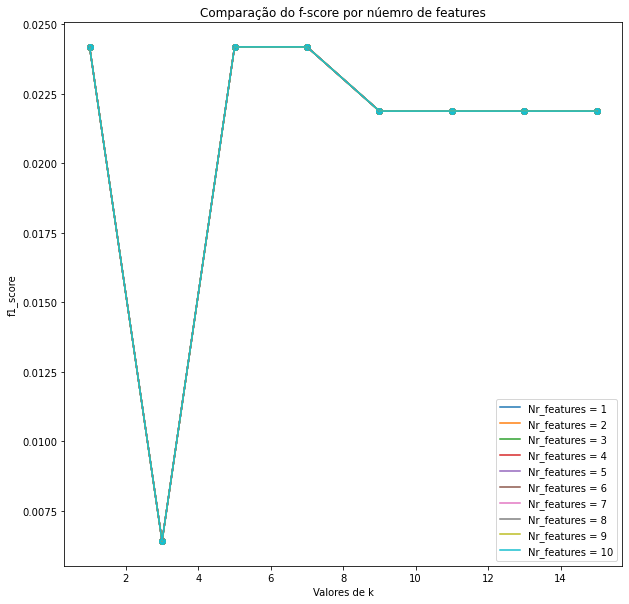

In [41]:
newActivity_elbow, df3, str_print = repeatTVT(feature_data,new_target, reliefF(feature_data, new_target), 10)

### 3.2. Elbow Graph

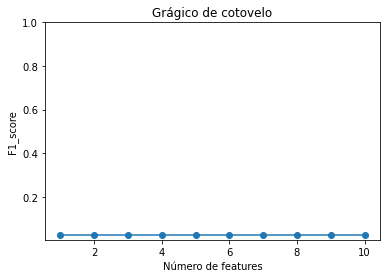

In [42]:
elbowGraph(newActivity_elbow, 11)

### 3.3. Validation set results

In [43]:
display(df3)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.024193,0.006405,0.024193,0.024193,0.021883,0.021883,0.021883,0.021883
Nº of features: 2,0.024193,0.006405,0.024193,0.024193,0.021883,0.021883,0.021883,0.021883
Nº of features: 3,0.024193,0.006405,0.024193,0.024193,0.021883,0.021883,0.021883,0.021883
Nº of features: 4,0.024193,0.006405,0.024193,0.024193,0.021883,0.021883,0.021883,0.021883
Nº of features: 5,0.024193,0.006405,0.024193,0.024193,0.021883,0.021883,0.021883,0.021883
Nº of features: 6,0.024193,0.006405,0.024193,0.024193,0.021883,0.021883,0.021883,0.021883
Nº of features: 7,0.024193,0.006405,0.024193,0.024193,0.021883,0.021883,0.021883,0.021883
Nº of features: 8,0.024193,0.006405,0.024193,0.024193,0.021883,0.021883,0.021883,0.021883
Nº of features: 9,0.024193,0.006405,0.024193,0.024193,0.021883,0.021883,0.021883,0.021883
Nº of features: 10,0.024193,0.006405,0.024193,0.024193,0.021883,0.021883,0.021883,0.021883


### 3.4. Test set results

In [44]:
print(str_print)

Nr of features: 1
Best K: 1
F1_score: 0.023640575076990585
--------------------------------------------------
Nr of features: 2
Best K: 1
F1_score: 0.023640575076990585
--------------------------------------------------
Nr of features: 3
Best K: 1
F1_score: 0.023640575076990585
--------------------------------------------------
Nr of features: 4
Best K: 1
F1_score: 0.023640575076990585
--------------------------------------------------
Nr of features: 5
Best K: 1
F1_score: 0.023640575076990585
--------------------------------------------------
Nr of features: 6
Best K: 1
F1_score: 0.023640575076990585
--------------------------------------------------
Nr of features: 7
Best K: 1
F1_score: 0.023640575076990585
--------------------------------------------------
Nr of features: 8
Best K: 1
F1_score: 0.023640575076990585
--------------------------------------------------
Nr of features: 9
Best K: 1
F1_score: 0.023640575076990585
--------------------------------------------------
Nr of feat

### 4. Neural net

In [45]:
from sklearn.neural_network import MLPClassifier

dataTVT = train_validation_test(feature_data, new_target, 0.4, 0.3)

def plot_f1_2(metr, neur_evol):
    plt.figure()

    plt.plot(neur_evol, metr, label="f1")
    plt.scatter(neur_evol, metr)
    
    plt.title("Evolução do f1-score")
    plt.xlabel("Número de neurónios")
    plt.ylabel("f1-score")
    plt.show()

### 4.1. Fixed learning speed

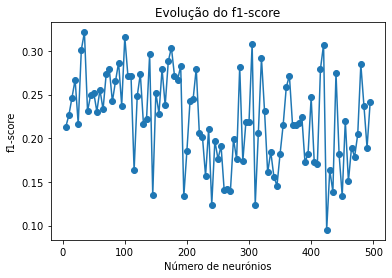

Best neurons number: 35


,Metrics
Recall,0.379572
Precision,0.152736
F1-score,0.216839


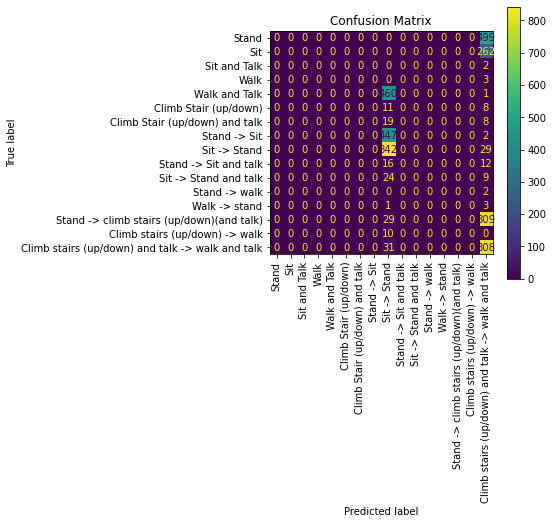

In [46]:
from sklearn.preprocessing import StandardScaler  

def mlp_4(type_speed):
    nns = []
    metrF1 = []

    neur_evol = np.arange(5, 500, 5)

    for i in neur_evol:
        if type_speed == 'fixed':
            clf = MLPClassifier(activation='logistic', solver='sgd', learning_rate_init=0.1, hidden_layer_sizes=i, max_iter=2000)
        elif type_speed == 'variable':
            clf = MLPClassifier(activation='logistic', learning_rate='invscaling', solver='sgd', learning_rate_init=0.1, hidden_layer_sizes=i, max_iter=2000)
        else:
             clf = MLPClassifier(activation='logistic', hidden_layer_sizes=i, solver='sgd', learning_rate_init=0.1, momentum=0.5, max_iter=2000)
        
        nns.append(clf.fit(dataTVT["TRAIN"][0], dataTVT["TRAIN"][1]))

        pred = clf.predict(dataTVT["VALIDATION"][0])

        true = dataTVT['VALIDATION'][1]
        
        cm, rs, ps, f1 = metrics(true, pred)

        metrF1.append(f1)

    plot_f1_2(metrF1, neur_evol)

    print("Best neurons number: " + str(neur_evol[np.argmax(metrF1)]))

    best_nns = np.argmax(metrF1)
    n_neur = neur_evol[best_nns]

    data_fin_x = np.concatenate((dataTVT["TRAIN"][0], dataTVT["VALIDATION"][0]))
    data_fin_y = np.concatenate((dataTVT["TRAIN"][1], dataTVT["VALIDATION"][1]))

    if type_speed == 'fixed':
        clf = MLPClassifier(activation='logistic', solver='sgd', learning_rate_init=0.1, hidden_layer_sizes=n_neur, max_iter=2000)
    elif type_speed == 'variable':
        clf = MLPClassifier(activation='logistic', learning_rate='invscaling', solver='sgd', learning_rate_init=0.1, hidden_layer_sizes=n_neur, max_iter=2000)
    else:
        clf = MLPClassifier(activation='logistic', hidden_layer_sizes=n_neur, solver='sgd', learning_rate_init=0.1, momentum=0.5, max_iter=2000)

    clf.fit(data_fin_x, data_fin_y)

    pred = clf.predict(dataTVT["TEST"][0])
    true = dataTVT['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)
    mais_bonito(cm, rs, ps, f1, activities)

mlp_4('fixed')


### 4.2. Variable learning speed

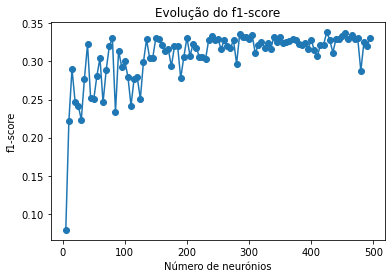

Best neurons number: 425


,Metrics
Recall,0.421900
Precision,0.331399
F1-score,0.336734


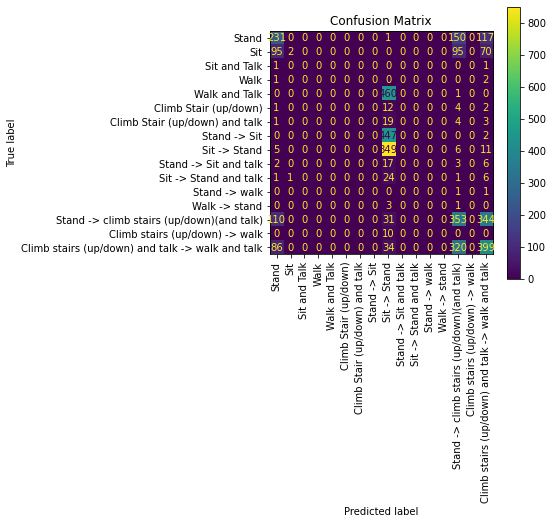

In [47]:
mlp_4('variable')

### 4.3. Momentum coeficient

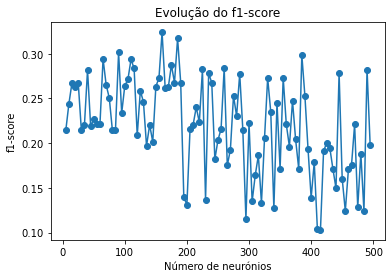

Best neurons number: 160


,Metrics
Recall,0.408098
Precision,0.419452
F1-score,0.273802


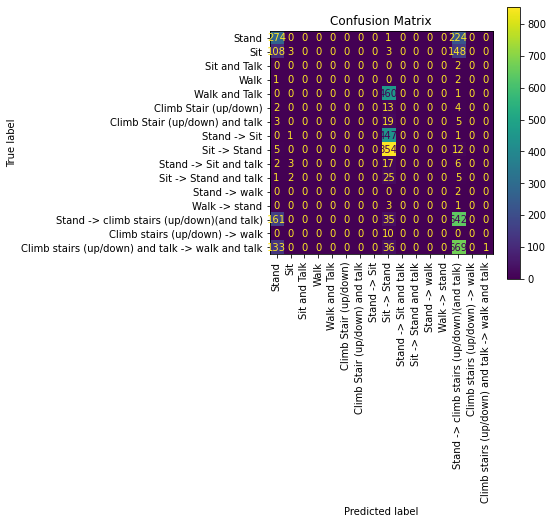

In [48]:
mlp_4('momentum')

### 4.4. Conclusões

Pelos gráficos acima, percebemos que apenas com taxa de aprendizagem variável existe uma evolução consistente da métrica f1-score, com número de neurónios variável. É nesse também que obtemos o maior valor de f1-score.

### 5. Neural net from scratch

In [85]:
class NeuralNetwork:
    def __init__(self, x, y, nr_neuronios, nr_fet):
        self.input      = x
        self.weights1   = np.random.rand(self.input.shape[1], nr_neuronios) 
        self.weights2   = np.random.rand(nr_neuronios, nr_fet)                 
        self.y          = y
        self.output     = np.zeros(self.y.shape)

    def feedforward(self):
        self.layer1 = self.sigmoid(np.dot(self.input, self.weights1))
        self.output = self.sigmoid(np.dot(self.layer1, self.weights2))

    def backprop(self):
        # application of the chain rule to find derivative of the loss function with respect to weights2 and weights1
        d_weights2 = np.dot(self.layer1.T, (2*(self.y - self.output) * self.sigmoid_derivative(self.output)))
        d_weights1 = np.dot(self.input.T,  (np.dot(2*(self.y - self.output) * self.sigmoid_derivative(self.output), self.weights2.T) * self.sigmoid_derivative(self.layer1)))

        # update the weights with the derivative (slope) of the loss function
        self.weights1 += d_weights1
        self.weights2 += d_weights2

    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))


    def sigmoid_derivative(self, x):
        return x * (1.0 - x)

### A nossa rede neuronal para o dataset Iris

,Metrics
Recall,0.920000
Precision,0.930285
F1-score,0.917314


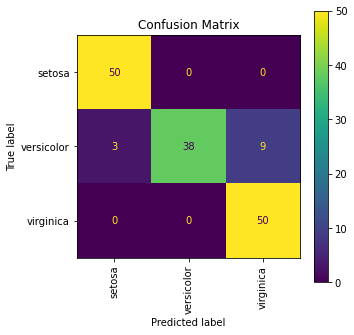

In [ ]:
iris = datasets.load_iris()

data = iris.data
for i in range(data.shape[1]):
    data[:,i] = (data[:,i] - data[:,i].mean()) / data[:,i].std()

target = iris.target
matriz_bin = np.zeros((len(target),3))
for i in range(len(matriz_bin)):
    matriz_bin[i, target[i]] = 1

rn = NeuralNetwork(data, matriz_bin, 4, 3)
for i in range(2000):
    rn.feedforward()
    rn.backprop()

max_line = []
for i in range(rn.output.shape[0]):
    max_line.append(np.argmax(rn.output[i,:]))

cm, rs, ps, f1 = metrics(target, max_line)
mais_bonito(cm, rs, ps, f1, iris["target_names"])


### A nossa rede neuronal para o dataset das features das atividades humanas

In [ ]:
def change(type):
    dataTVT[type][1][dataTVT[type][1] == "Stand"] = 0
    dataTVT[type][1][dataTVT[type][1] == "Sit"] = 1
    dataTVT[type][1][dataTVT[type][1] == "Sit and Talk"] = 2
    dataTVT[type][1][dataTVT[type][1] == "Walk"] = 3
    dataTVT[type][1][dataTVT[type][1] == "Walk and Talk"] = 4
    dataTVT[type][1][dataTVT[type][1] == "Climb Stair (up/down)"] = 5
    dataTVT[type][1][dataTVT[type][1] == "Climb Stair (up/down) and talk"] = 6
    dataTVT[type][1][dataTVT[type][1] == "Stand -> Sit"] = 7
    dataTVT[type][1][dataTVT[type][1] == "Sit -> Stand"] = 8
    dataTVT[type][1][dataTVT[type][1] == "Stand -> Sit and talk"] = 9
    dataTVT[type][1][dataTVT[type][1] == "Sit -> Stand and talk"] = 10
    dataTVT[type][1][dataTVT[type][1] == "Stand -> walk"] = 11
    dataTVT[type][1][dataTVT[type][1] == "Walk -> stand"] = 12
    dataTVT[type][1][dataTVT[type][1] == "Stand -> climb stairs (up/down)(and talk)"] = 13
    dataTVT[type][1][dataTVT[type][1] == "Climb stairs (up/down) -> walk"] = 14
    dataTVT[type][1][dataTVT[type][1] == "Climb stairs (up/down) and talk -> walk and talk"] = 15

    dataTVT[type][1] = dataTVT[type][1].astype('float64')

Número de neurónios: 4
Número de neurónios: 14
Número de neurónios: 24
Número de neurónios: 34
Número de neurónios: 44
Número de neurónios: 54
Número de neurónios: 64
Número de neurónios: 74
Número de neurónios: 84
Número de neurónios: 94
Número de neurónios: 104
Número de neurónios: 114
Número de neurónios: 124
Número de neurónios: 134
Número de neurónios: 144
Número de neurónios: 154
Número de neurónios: 164
Número de neurónios: 174
Número de neurónios: 184
Número de neurónios: 194


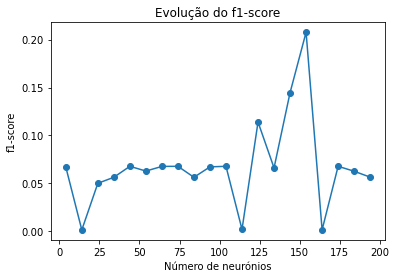

Best neurons number: 154


,Metrics
Recall,0.006671
Precision,0.000045
F1-score,0.000088


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,0,0,0,0,886,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,495,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,494,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,753,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,855,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,505,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,243,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0


In [ ]:
import warnings
warnings.filterwarnings('ignore')

dataTVT = train_validation_test(feature_data, new_target, 0.4, 0.3)
change("TRAIN")
change("TEST")
change("VALIDATION")


for i in range(dataTVT["TRAIN"][0].shape[1]):
    if(dataTVT["TRAIN"][0][:,i].std() != 0):
        dataTVT["TRAIN"][0][:,i] = (dataTVT["TRAIN"][0][:,i] - dataTVT["TRAIN"][0][:,i].mean()) / dataTVT["TRAIN"][0][:,i].std()

matriz_bin = np.zeros((len(dataTVT["TRAIN"][1]), 16))
for i in range(len(matriz_bin)):
    matriz_bin[i, int(dataTVT["TRAIN"][1][i])] = 1

neur_evol = np.arange(4, 200, 10)

metrF1 = []

for j in neur_evol:
    print("Número de neurónios: " + str(j))
    rn = NeuralNetwork(dataTVT["TRAIN"][0], matriz_bin, j, 16)
    for i in range(5000):
        rn.feedforward()
        rn.backprop()

    layer1 = rn.sigmoid(np.dot(dataTVT["VALIDATION"][0], rn.weights1))
    output = rn.sigmoid(np.dot(layer1, rn.weights2))
    pred = []
    for i in range(output.shape[0]):
        pred.append(np.argmax(output[i,:]))

    true = dataTVT['VALIDATION'][1]
    cm, rs, ps, f1 = metrics(true, pred)

    metrF1.append(f1)

plot_f1_2(metrF1, neur_evol)

print("Best neurons number: " + str(neur_evol[np.argmax(metrF1)]))
best_nns = np.argmax(metrF1)
n_neur = neur_evol[best_nns]

data_fin_x = np.concatenate((dataTVT["TRAIN"][0], dataTVT["VALIDATION"][0]))
data_fin_y = np.concatenate((dataTVT["TRAIN"][1], dataTVT["VALIDATION"][1]))

for i in range(data_fin_x.shape[1]):
    if(data_fin_x[:,i].std() != 0):
        data_fin_x[:,i] = (data_fin_x[:,i] - data_fin_x[:,i].mean()) / data_fin_x[:,i].std()

matriz_bin = np.zeros((len(data_fin_y), 16))
for i in range(len(matriz_bin)):
    matriz_bin[i, int(data_fin_y[i])] = 1

rn = NeuralNetwork(data_fin_x, matriz_bin, n_neur, 16)
for i in range(5000):
    rn.feedforward()
    rn.backprop()

layer1 = rn.sigmoid(np.dot(dataTVT["TEST"][0], rn.weights1))
pred = rn.sigmoid(np.dot(layer1, rn.weights2))
output = rn.sigmoid(np.dot(layer1, rn.weights2))
pred = []
for i in range(output.shape[0]):
    pred.append(np.argmax(output[i,:]))

true = dataTVT['TEST'][1]
cm, rs, ps, f1 = metrics(true, pred)
mais_bonito(cm, rs, ps, f1, activities)
